In [395]:
import pandas as pd

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rcParams['timezone'] = 'Europe/Berlin'

import data_process_base
import importlib
importlib.reload(data_process_base)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

In [396]:
# create random time series from import data
da = data_process_base.DataAction()
nc = data_process_base.net_calc()

keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)

Number of data frame segments =  90
dfList created successfully.


In [397]:
def end_val_make(sgen_val, iter):
    """
    Final boss

    """
    # create df to store output
    col_names = ['line_1', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_8']
    end_val = pd.DataFrame(columns=col_names)

    for i in range(0, iter):
        # iterative scramble
        night_merge = da.power_merge()

        # assign generator value at random times
        night_mw = da.sgen_comm(ts=night_merge, wind_length=60, sgen_val=sgen_val, parties=4)
        # night_mw = da.sgen_rand(ts=night_merge, sgen_val=sgen_val)

        nc.four_loads_branched_make(night_mw)
        nc.four_loads_branched_out("res_line", "loading_percent")
        nc.four_loads_branched_run()
        nc.four_loads_branched_read_loadpct()

        nc.end_val_step(nc.ll, end_val)

    return end_val


iter = 5
sgen_val = 0.01 # typical val: 0.010 MW = 10kW
end_val_make(sgen_val, iter)


100%|██████████| 601/601 [00:01<00:00, 336.80it/s]


Whoops, grabbing a different touple of dates...


100%|██████████| 601/601 [00:01<00:00, 357.84it/s]


,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8
0,56.468972,51.484959,18.422895,9.133596,12.431719,35.065035,16.349448,9.133854
1,50.315162,40.162887,18.271863,9.110358,19.846394,32.240272,13.700825,9.110618
2,45.534208,26.769295,20.646432,8.518267,25.297267,10.249458,12.754831,8.518544
3,72.160948,44.140620,31.546840,25.684304,38.949931,36.352967,12.524961,25.684396
4,41.685488,35.010870,20.674988,8.520559,11.305699,20.084129,15.179801,8.520836


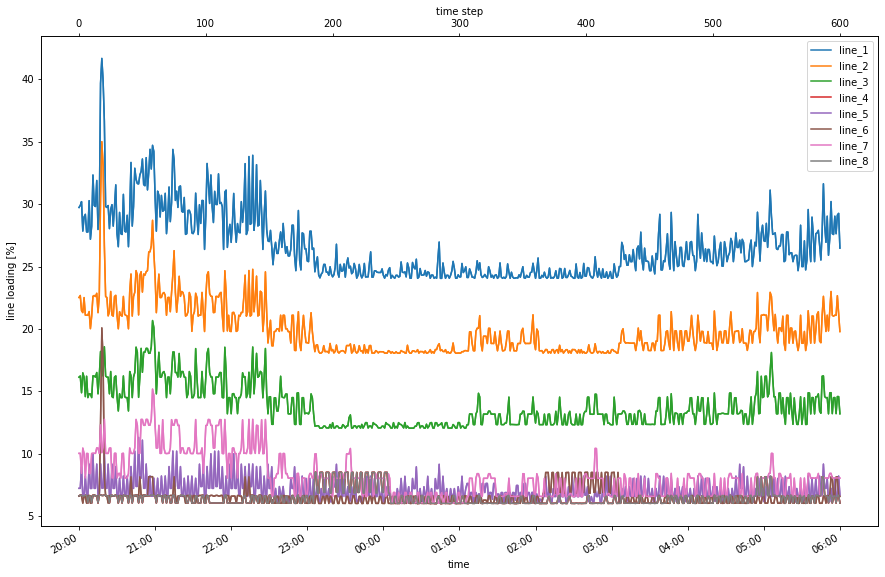

In [398]:
nc.four_loads_branched_plot_linepct()

100%|██████████| 2/2 [00:00<00:00, 49.96it/s]


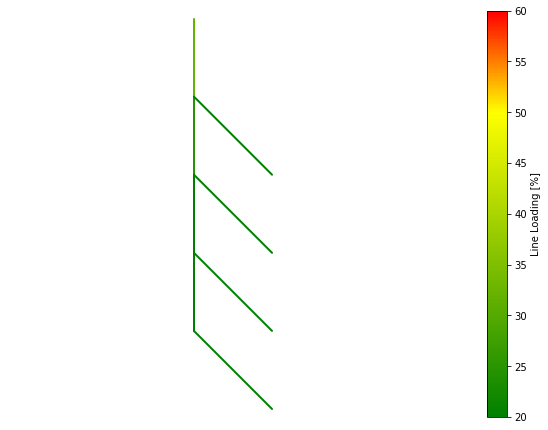

In [399]:
nc.load_graph(nc.net, time_step=45)

In [400]:
def end_times_make(df):
    """
    append time vals to end_times df
    
    """
    # get inputs
    col_names = df.columns.tolist()
    max_ind = df.idxmax()
    k = nc.night_mw.index.values[max_ind.tolist()]
    max_time = pd.to_datetime(k).strftime('%H:%M:%S').tolist()

    # create df to store output
    end_times = pd.DataFrame(dtype='str', columns=col_names)
    
    # append series as last line
    end_times.loc[end_times.shape[0]] = max_time

    return end_times


# end_times_make(nc.ll)